In [1]:
import brainpy.math as bm
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

from canns.models.basic import GridCell2DVelocity

# Setup environment
dt = 5e-4
bm.set_dt(dt)

# Create model
model = GridCell2DVelocity(
    length=40,          # Network size (40x40 neurons)
    tau=0.01,           # Time constant
    alpha=0.1,          # Shift gain
    W_l=3.0,            # Connection width
    lambda_net=17.0,    # Grid spacing parameter
)

print(f"Network: {model.num} neurons ({model.length}×{model.length})")
print(f"Grid spacing (λ): {model.lambda_net}")

/home/sichaohe/miniconda3/envs/canns/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Network: 1600 neurons (40×40)
Grid spacing (λ): 17.0


In [2]:
# Heal network (stabilize initial state)
print("Healing network...")
model.heal_network(
    num_healing_steps=5000,
    dt_healing=1e-4
)
print("Healing complete!")

Healing network...


  0%|          | 0/10000 [00:00<?, ?it/s]

Healing complete!


<OpenLoopNavigationTask>Generating Task data: 100%|██████████| 5000/5000 [00:00<00:00, 1044502.44it/s]

Trajectory: 5000 steps, 50.0s
Environment: 2.2m × 2.2m


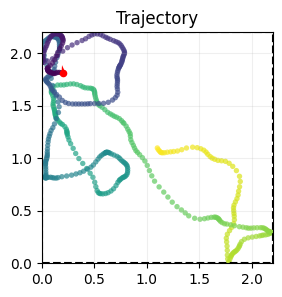

In [3]:
from canns.task.open_loop_navigation import OpenLoopNavigationTask

# Task parameters
box_size = 2.2
duration = 50.0
dt_task = 0.01

# Create navigation task
task = OpenLoopNavigationTask(
    duration=duration,
    width=box_size,
    height=box_size,
    start_pos=[box_size/2, box_size/2],
    speed_mean=0.2,
    speed_std=0.05,
    dt=dt_task,
)
task.get_data()

# Extract data
true_positions = np.asarray(task.data.position)
velocities = task.data.velocity

print(f"Trajectory: {len(true_positions)} steps, {duration}s")
print(f"Environment: {box_size}m × {box_size}m")

task.show_data()

In [4]:
# Run simulation
print("Running path integration...")

def run_step(vel):
    model(vel)
    return model.r.value

activities = bm.for_loop(run_step, (velocities,), progress_bar=True)
activities = np.asarray(activities)

print(f"Activity shape: {activities.shape}")
print("Path integration complete!")

Running path integration...


  0%|          | 0/5000 [00:00<?, ?it/s]

Activity shape: (5000, 1600)
Path integration complete!


In [5]:
# Track blob centers
print("Tracking blob centers...")
blob_centers = GridCell2DVelocity.track_blob_centers(activities, model.length)

# Compute displacements
blob_displacement = np.diff(blob_centers, axis=0)

# Jump correction (handle periodic boundary crossings)
threshold = 3.0
displacement_norm = np.linalg.norm(blob_displacement, axis=1)
jump_indices = np.where(displacement_norm > threshold)[0]

if len(jump_indices) > 0:
    print(f"Correcting {len(jump_indices)} jumps (periodic boundaries)")
    for idx in jump_indices:
        if idx > 0 and idx < len(blob_displacement) - 1:
            blob_displacement[idx] = (blob_displacement[idx - 1] + blob_displacement[idx + 1]) / 2

# Integrate to get estimated trajectory
estimated_pos_neuron = np.cumsum(blob_displacement, axis=0)

print(f"Blob tracking complete!")
print(f"Estimated trajectory: {estimated_pos_neuron.shape}")

Tracking blob centers...
Correcting 4 jumps (periodic boundaries)
Blob tracking complete!
Estimated trajectory: (4999, 2)


In [6]:
# Align with true positions
true_pos_rel = true_positions - true_positions[0]
true_pos_aligned = true_pos_rel[:len(estimated_pos_neuron)]

# Linear regression for scaling
X = estimated_pos_neuron.flatten().reshape(-1, 1)
y = true_pos_aligned.flatten()

reg = LinearRegression(fit_intercept=False)
reg.fit(X, y)
prop_factor = reg.coef_[0]
r2_score = reg.score(X, y)

# Rescale and compute errors
estimated_pos_physical = prop_factor * estimated_pos_neuron + true_positions[0]
position_errors = np.linalg.norm(
    estimated_pos_physical - true_positions[:len(estimated_pos_physical)], axis=1
)

# Results
print("="*70)
print("Path Integration Quality:")
print(f"  R² score: {r2_score:.6f}")
print(f"  Proportional factor: {prop_factor:.6f}")
print(f"\nPosition Errors:")
print(f"  Mean: {np.mean(position_errors):.4f}m")
print(f"  Max: {np.max(position_errors):.4f}m")
print(f"  Final: {position_errors[-1]:.4f}m")

if r2_score > 0.99:
    print(f"\n✅ EXCELLENT: R² > 0.99 (high-quality path integration)")
elif r2_score > 0.95:
    print(f"\n✓ GOOD: R² > 0.95")
else:
    print(f"\n⚠️  LOW R²: Path integration quality needs improvement")
print("="*70)

Path Integration Quality:
  R² score: 0.986375
  Proportional factor: -0.178128

Position Errors:
  Mean: 0.1048m
  Max: 0.2253m
  Final: 0.0744m

✓ GOOD: R² > 0.95


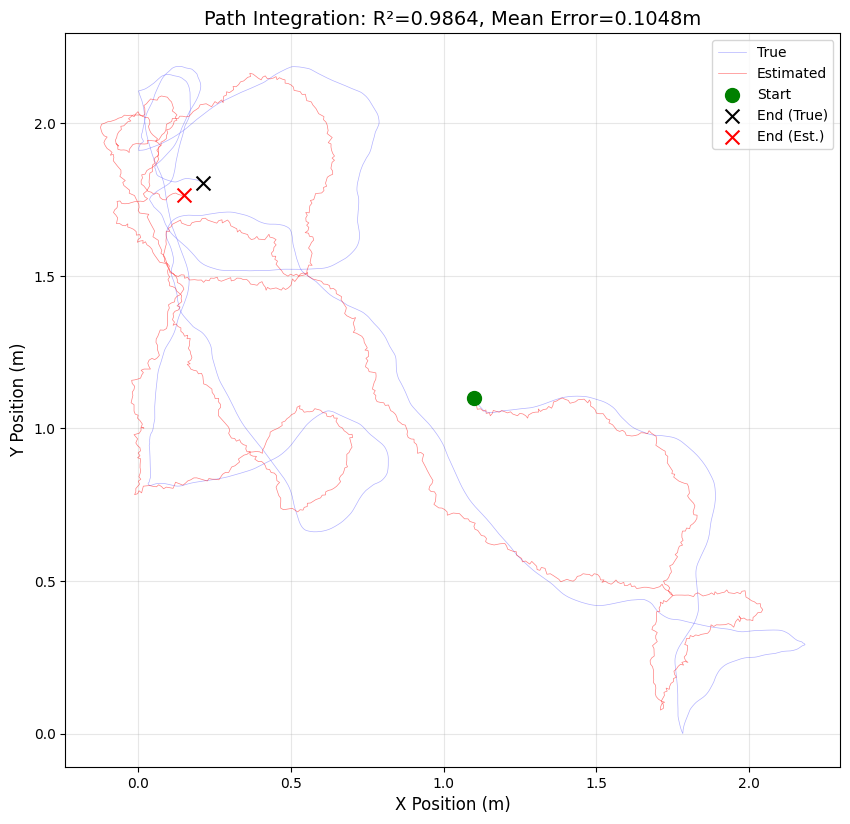

In [7]:
# Trajectory comparison
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(
    true_positions[:len(estimated_pos_physical), 0],
    true_positions[:len(estimated_pos_physical), 1],
    "b-", alpha=0.3, linewidth=0.5, label="True"
)
ax.plot(
    estimated_pos_physical[:, 0],
    estimated_pos_physical[:, 1],
    "r-", alpha=0.5, linewidth=0.5, label="Estimated"
)

ax.scatter(true_positions[0, 0], true_positions[0, 1],
           c="green", s=100, marker="o", label="Start", zorder=5)
ax.scatter(true_positions[len(estimated_pos_physical)-1, 0],
           true_positions[len(estimated_pos_physical)-1, 1],
           c="black", s=100, marker="x", label="End (True)", zorder=5)
ax.scatter(estimated_pos_physical[-1, 0], estimated_pos_physical[-1, 1],
           c="red", s=100, marker="x", label="End (Est.)", zorder=5)

ax.set_xlabel("X Position (m)", fontsize=12)
ax.set_ylabel("Y Position (m)", fontsize=12)
ax.set_title(
    f"Path Integration: R²={r2_score:.4f}, Mean Error={np.mean(position_errors):.4f}m",
    fontsize=14
)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect("equal")
plt.show()

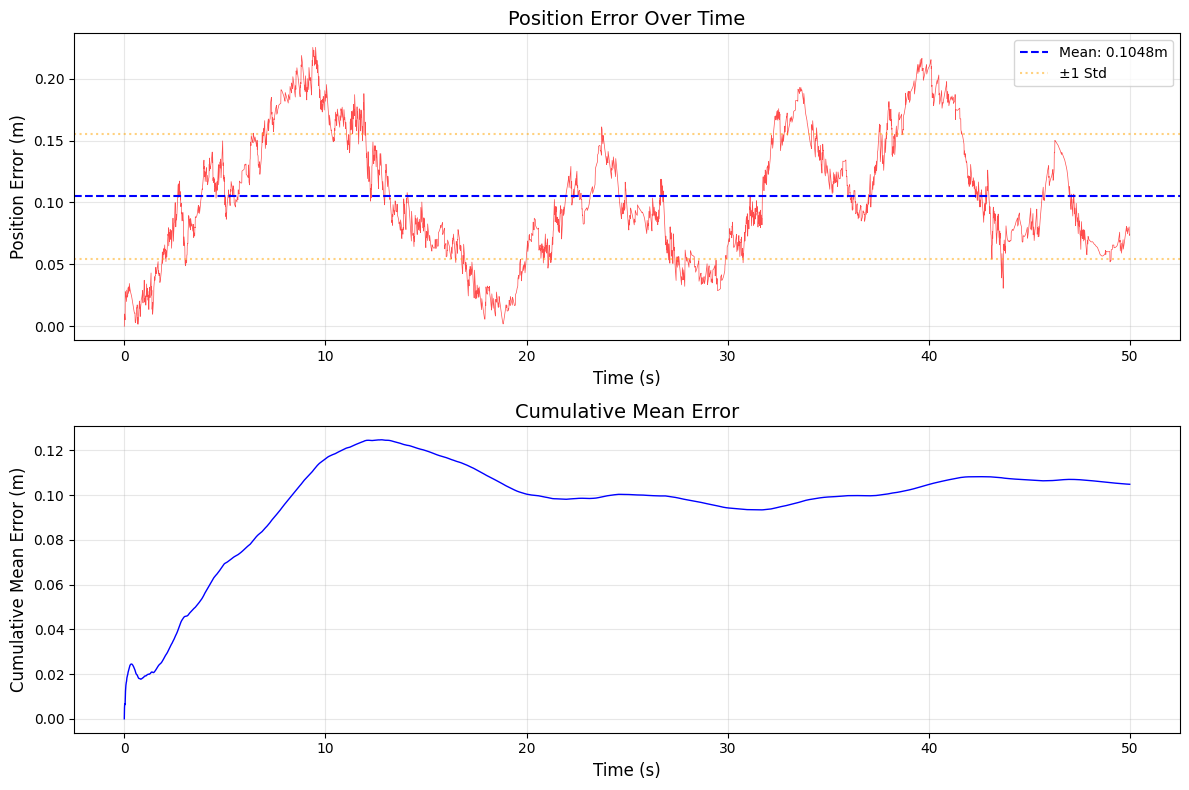

In [8]:
# Error over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

time_steps = np.arange(len(position_errors)) * dt_task

# Instantaneous error
ax1.plot(time_steps, position_errors, "r-", linewidth=0.5, alpha=0.7)
ax1.axhline(np.mean(position_errors), color="blue", linestyle="--",
            label=f"Mean: {np.mean(position_errors):.4f}m")
ax1.axhline(np.mean(position_errors) + np.std(position_errors),
            color="orange", linestyle=":", alpha=0.5, label="±1 Std")
ax1.axhline(np.mean(position_errors) - np.std(position_errors),
            color="orange", linestyle=":", alpha=0.5)
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("Position Error (m)", fontsize=12)
ax1.set_title("Position Error Over Time", fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Cumulative mean error
cumulative_mean = np.cumsum(position_errors) / np.arange(1, len(position_errors) + 1)
ax2.plot(time_steps, cumulative_mean, "b-", linewidth=1)
ax2.set_xlabel("Time (s)", fontsize=12)
ax2.set_ylabel("Cumulative Mean Error (m)", fontsize=12)
ax2.set_title("Cumulative Mean Error", fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [2]:
from canns.analyzer.metrics.systematic_ratemap import compute_systematic_ratemap

# Create a fresh model for spatial analysis
model_spatial = GridCell2DVelocity(
    length=50,
    tau=0.01,
    alpha=0.1,
    W_l=2.0,
    lambda_net=17.0,
)

print(f"Network: {model_spatial.num} neurons")

# Healing
print("Running healing process...")
model_spatial.heal_network(num_healing_steps=10000, dt_healing=1e-4)

# Compute rate maps via systematic sampling
print("Computing rate maps via systematic sampling...")

box_width = 2.2
box_height = 2.2
spatial_resolution = 100

ratemaps = compute_systematic_ratemap(
    model_spatial,
    box_width=box_width,
    box_height=box_height,
    resolution=spatial_resolution,
    speed=0.3,
    num_batches=10,
    verbose=True,
)

# Transpose to (num_neurons, height, width) format
firing_fields = np.transpose(ratemaps, (2, 0, 1))
print(f"Firing fields shape: {firing_fields.shape}")

Network: 2500 neurons
Running healing process...


Running for 10,000 iterations: 100%|██████████| 10000/10000 [00:00<00:00, 17218.65it/s]


Computing rate maps via systematic sampling...
Computing systematic rate maps...
  Resolution: 100×100
  Arena: 2.2×2.2m
  Speed: 0.3 m/s, dt: 0.0005s, dx: 0.00015m
  Step 1: Horizontal sweep (14666 steps)
  Step 2: Recording states at 100 horizontal positions...
  Step 3: Vertical sampling in 10 batches...


Batching: 100%|██████████| 10/10 [01:01<00:00,  6.11s/it]

  ✓ Rate maps computed: shape=(100, 100, 2500)
    Activity range: [0.0000, 0.5675]
Firing fields shape: (2500, 100, 100)


In [3]:
from canns.analyzer.metrics.spatial_metrics import gaussian_smooth_heatmaps

# Apply smoothing
firing_fields_smooth = gaussian_smooth_heatmaps(firing_fields, sigma=2.0)

print(f"Smoothed firing fields: {firing_fields_smooth.shape}")

Smoothed firing fields: (2500, 100, 100)


In [4]:
# Select top cells based on max firing rate
num_cells_to_analyze = 5
max_rates = np.max(firing_fields_smooth, axis=(1, 2))
top_cell_indices = np.argsort(max_rates)[-num_cells_to_analyze:][::-1]

print(f"Top {num_cells_to_analyze} cells: {top_cell_indices}")
print(f"Max firing rates: {max_rates[top_cell_indices]}")

Top 5 cells: [2026 2024 2048 2077 2176]
Max firing rates: [0.52674343 0.52674342 0.51486383 0.50624289 0.50595154]


In [5]:
from canns.analyzer.metrics.spatial_metrics import (
    compute_spatial_autocorrelation,
    compute_grid_score,
    find_grid_spacing,
)
from canns.analyzer.visualization import (
    plot_firing_field_heatmap,
    plot_autocorrelation,
    plot_grid_score,
    PlotConfigs,
)

# Analyze each cell
grid_scores = []
grid_spacings = []

cell_idx = top_cell_indices[0]  # Example for single cell analysis

rate_map = firing_fields_smooth[cell_idx]

# Compute spatial autocorrelation
autocorr = compute_spatial_autocorrelation(rate_map)

# Compute grid score
grid_score, rotated_corrs = compute_grid_score(autocorr)

# Find grid spacing
bin_size = box_width / spatial_resolution
spacing_bins, spacing_real = find_grid_spacing(autocorr, bin_size=bin_size)

grid_scores.append(grid_score)
grid_spacings.append(spacing_real)

print(f"Cell {cell_idx}: Grid Score={grid_score:.3f}, Spacing={spacing_real:.3f}m")

# Summary statistics
avg_grid_score = np.mean(grid_scores)
avg_spacing = np.mean(grid_spacings)

print(f"\nMean grid score: {avg_grid_score:.3f}")
print(f"Mean grid spacing: {avg_spacing:.3f}m")

Cell 2026: Grid Score=0.501, Spacing=0.070m

Mean grid score: 0.501
Mean grid spacing: 0.070m


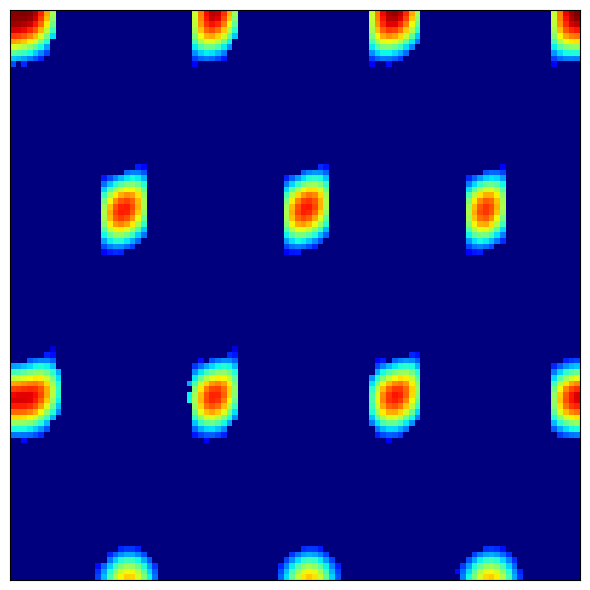

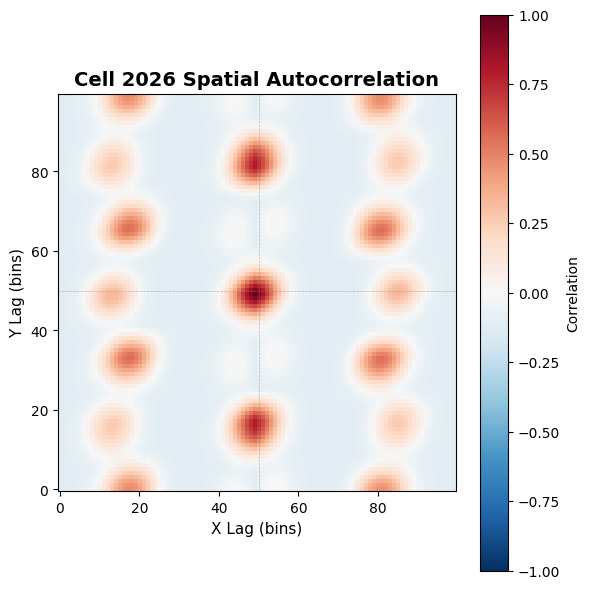

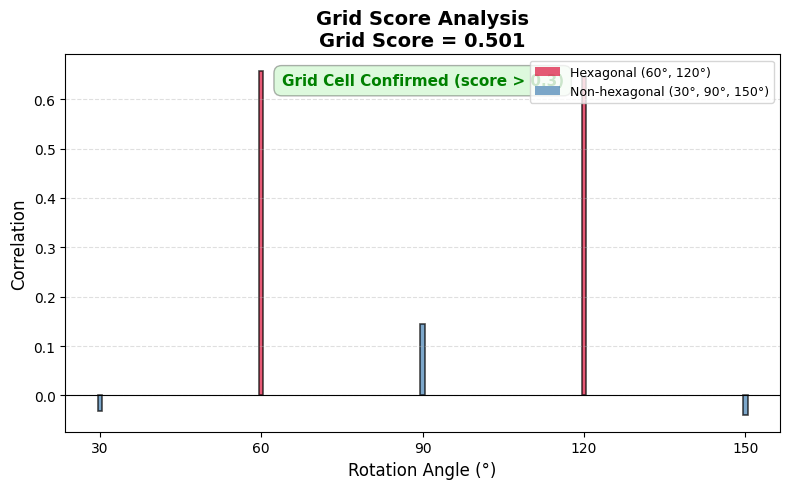

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Grid Score Analysis\nGrid Score = 0.501'}, xlabel='Rotation Angle (°)', ylabel='Correlation'>)

In [6]:
# Visualize rate maps and autocorrelations
cell_idx = top_cell_indices[0]  # Example for single cell visualization
rate_map = firing_fields_smooth[cell_idx]
autocorr = compute_spatial_autocorrelation(rate_map)
grid_score, rotated_corrs = compute_grid_score(autocorr)

# Rate map
plot_firing_field_heatmap(
    rate_map,
    config=PlotConfigs.firing_field_heatmap(
        title=f"Cell {cell_idx} Firing Field (Grid Score={grid_score:.3f})",
        show=True,
    ),
)

# Autocorrelation
plot_autocorrelation(
    autocorr,
    config=PlotConfigs.grid_autocorrelation(
        title=f"Cell {cell_idx} Spatial Autocorrelation",
        show=True,
    ),
)

# Grid score plot
plot_grid_score(
    rotated_corrs,
    grid_score,
    config=PlotConfigs.grid_score_plot(show=True),
)

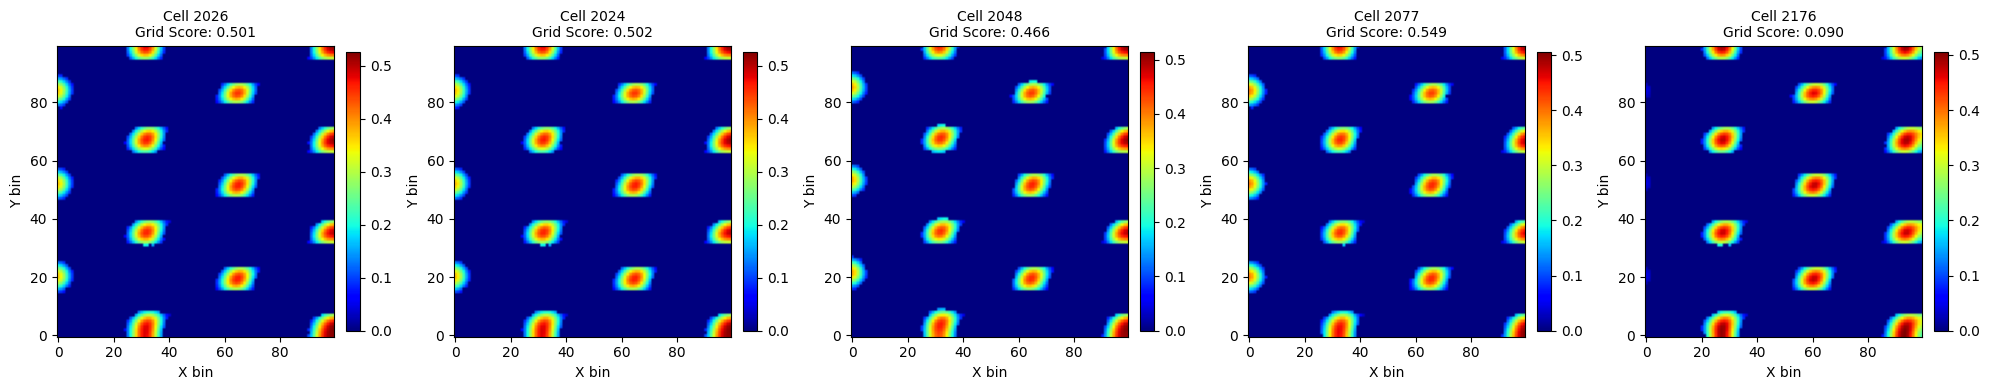

In [7]:
# Summary figure with all rate maps
fig, axes = plt.subplots(1, num_cells_to_analyze, figsize=(4 * num_cells_to_analyze, 4))

if num_cells_to_analyze == 1:
    axes = [axes]

for i, cell_idx in enumerate(top_cell_indices):
    rate_map = firing_fields_smooth[cell_idx]
    autocorr = compute_spatial_autocorrelation(rate_map)
    grid_score, _ = compute_grid_score(autocorr)

    im = axes[i].imshow(rate_map, cmap="jet", origin="lower", aspect="auto")
    axes[i].set_title(f"Cell {cell_idx}\nGrid Score: {grid_score:.3f}", fontsize=10)
    axes[i].set_xlabel("X bin")
    axes[i].set_ylabel("Y bin")
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [8]:
from sklearn.decomposition import PCA

# Reshape for PCA (neurons x positions)
data_for_pca = firing_fields.reshape(firing_fields.shape[0], -1).T

# Perform PCA
pca = PCA(n_components=8)
projected_data = pca.fit_transform(data_for_pca)
explained_variance = pca.explained_variance_ratio_

print(f"Explained variance (first 8 PCs): {explained_variance}")
print(f"Cumulative variance: {np.cumsum(explained_variance)}")

Explained variance (first 8 PCs): [0.07972459 0.07232635 0.07066396 0.06941219 0.06820266 0.06509864
 0.06219304 0.04610018]
Cumulative variance: [0.07972459 0.15205094 0.2227149  0.29212709 0.36032975 0.42542839
 0.48762144 0.53372161]


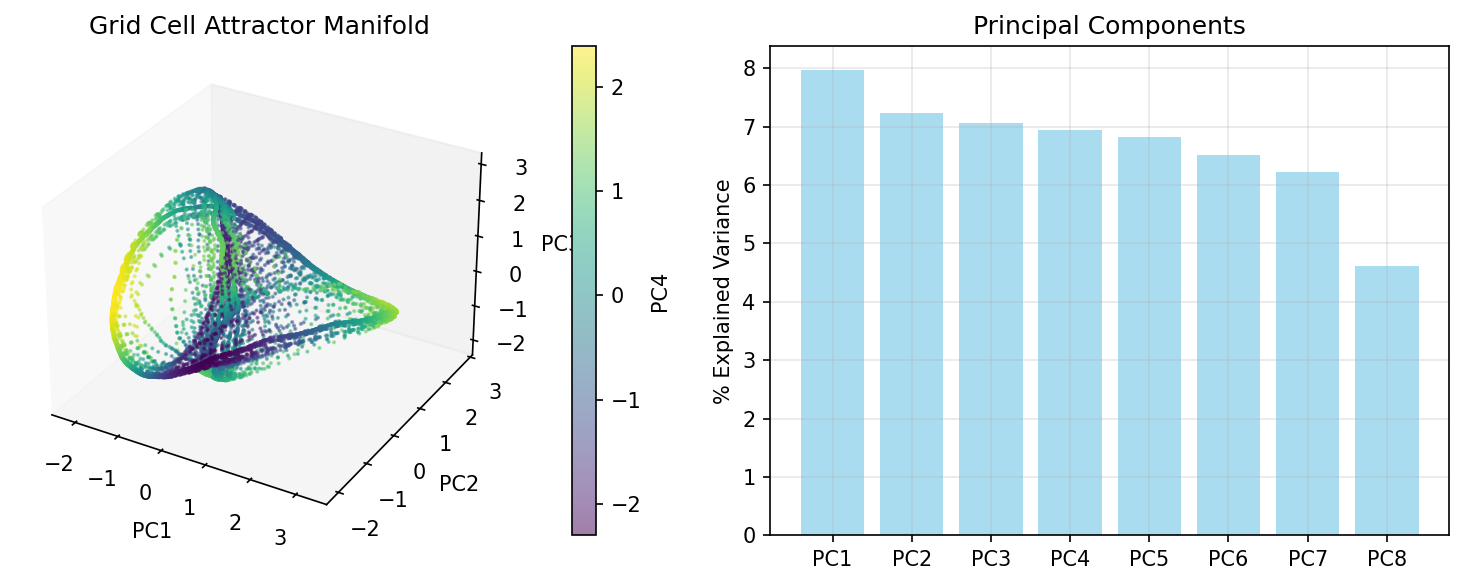

In [9]:
from mpl_toolkits.mplot3d import Axes3D

# 3D visualization
fig = plt.figure(figsize=(10, 4), dpi=150)

# 3D scatter
ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(
    projected_data[:, 0],
    projected_data[:, 1],
    projected_data[:, 2],
    c=projected_data[:, 3],
    cmap='viridis',
    s=1,
    alpha=0.5
)

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('Grid Cell Attractor Manifold')
ax1.grid(False)
fig.colorbar(scatter, ax=ax1, label='PC4', pad=0.1)

# Variance explained
ax2 = fig.add_subplot(122)
components = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']
ax2.bar(components, 100 * explained_variance, color='skyblue', alpha=0.7)
ax2.set_ylabel('% Explained Variance')
ax2.set_title('Principal Components')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()